In [285]:
%config IPCompleter.use_jedi = False
import numpyro
numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

from jax import numpy as jnp
from jax import random

import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az

from dfply import *

%run -i 'model_helpers.py'

In [260]:
df = load_data() # see data_helpers.py
df.head()

In [262]:
X_data, y_data = make_model_data(df) # see data_helpers.py

,querydetail,querytype,ID,estimate,coldrainy,conjdisj_trial
0,cold,A,0,0.676667,1,0
1,windy,A,0,0.733333,0,0
2,cold and rainy,AandB,0,0.760000,1,1
3,windy and cloudy,AandB,0,0.773333,0,1
4,cold and not rainy,AandnotB,0,0.753333,1,1
...,...,...,...,...,...,...
3355,not rainy,notB,83,0.246667,1,0
3356,not cloudy given windy,notBgA,83,0.416667,0,0
3357,not rainy given cold,notBgA,83,0.500000,1,0
3358,not cloudy given not windy,notBgnotA,83,0.326667,0,0


# Bayesian sampler model

In [292]:
def bayesian_sampler_complex(data, y=None):

    n_Ps = len(np.unique(data["subj"]))
    n_conds = len(np.unique(data["cond"]))
    trial = data["trial"]
    subj = data["subj"]
    cond = data["cond"]
    
    not_conjdisj = abs(1-data["conjdisj_trial"])

    # population level parameters/priors
    sigma = numpyro.sample("sigma", dist.HalfCauchy(.1)) # for Normal() response noise version
#     k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter

    # need a beta, and N's per person
    with numpyro.plate("subj", n_Ps):
        betas = numpyro.sample("beta", dist.Uniform(0.0, 1.0)) # bounded to [0,1] as in paper
        N_deltas = numpyro.sample("N_delta", dist.HalfNormal(50))
        N_primes = numpyro.sample("N_prime", dist.HalfNormal(50))
        
        # need a theta per person-query
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
    N = 1 + N_primes[subj] + N_deltas[subj] * not_conjdisj # they required N be at least 1, no pooling for now
    
    beta = betas[subj]
    theta_ind = ((subj*2)+cond)
    theta = thetas[theta_ind,:]
        
    numerator = jnp.sum(theta*data["X_num"], axis=-1)
    denom = jnp.sum(theta*data["X_denom"], axis=-1)
    pi = jnp.divide(numerator, denom)
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)

    with numpyro.plate("data", len(trial)):
        yhat = numpyro.sample("yhat", dist.Normal(p_bs, sigma), obs = y) # wrong but replicates paper
#         yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)
    
    return yhat

In [293]:
mcmc_bs = MCMC(NUTS(bayesian_sampler_complex, target_accept_prob=.80), 
               num_warmup=2000, 
               num_samples=2_000, 
               num_chains=2)

mcmc_bs.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [302]:
# mcmc.print_summary()

In [296]:
az_data_bs = make_arviz_data(mcmc_bs, bayesian_sampler_complex, X_data) # see model_helpers.py

az.loo(az_data_bs, scale="deviance")

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:656: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 3360 log-likelihood matrix

             Estimate       SE
deviance_loo -3401.15    84.23
p_loo          489.66        -

There has been a warning during the calculation. Please check the results.

<AxesSubplot:xlabel='yhat'>

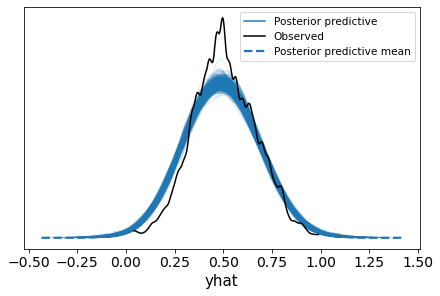

In [297]:
az.plot_ppc(az_data_bs, data_pairs={"yhat":"yhat"},num_pp_samples=500)

corr =  0.667


<AxesSubplot:xlabel='preds', ylabel='estimate'>

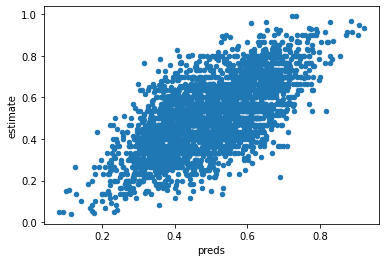

In [298]:
df_output = df
df_output["preds"] = az_data_bs.posterior_predictive.mean(dim=['chain', 'draw']).yhat
print("corr = ", np.round(np.corrcoef(df_test.estimate, df_test.preds)[0,1],3))
df_output.plot.scatter(x = "preds", y = "estimate")

corr =  0.819


<AxesSubplot:xlabel='mean_pred', ylabel='mean_est'>

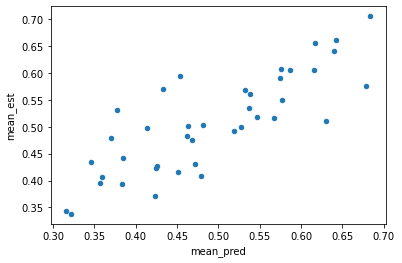

In [299]:
trial_df = df_output >> group_by(X.querytype, X.querydetail) >> summarize(mean_pred = np.mean(X.preds), mean_est = np.mean(X.estimate))
print("corr = ", np.round(np.corrcoef(trial_df.mean_est, trial_df.mean_pred)[0,1],3))
trial_df.plot.scatter(x="mean_pred", y="mean_est")

# Relative Frequency model


In [287]:
def relative_freq(data, y=None):

    n_Ps = len(np.unique(data["subj"]))
    n_conds = len(np.unique(data["cond"]))
    trial = data["trial"]
    subj = data["subj"]
    cond = data["cond"]

    # population level parameters/priors
    sigma = numpyro.sample("sigma", dist.HalfCauchy(.1)) # for Normal() response noise version
#     k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter

    # need a theta per person-query
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
    theta_ind = ((subj*2)+cond)
    theta = thetas[theta_ind,:]
        
    numerator = jnp.sum(theta*data["X_num"], axis=-1)
    denom = jnp.sum(theta*data["X_denom"], axis=-1)
    pi = jnp.divide(numerator, denom)

    with numpyro.plate("data", len(trial)):
        yhat = numpyro.sample("yhat", dist.Normal(pi, sigma), obs = y) # wrong but replicates paper
#         yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)
    
    return yhat

In [289]:
mcmc_rf = MCMC(NUTS(relative_freq, target_accept_prob=.80), 
               num_warmup=2000, 
               num_samples=2_000, 
               num_chains=2)

mcmc_rf.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [290]:
az_data_rf = make_arviz_data(mcmc_rf, relative_freq, X_data) # see model_helpers.py

az.loo(az_data_rf, scale="deviance")

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:656: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 3360 log-likelihood matrix

             Estimate       SE
deviance_loo -1609.55    80.52
p_loo          383.05        -

There has been a warning during the calculation. Please check the results.

corr =  0.549


<AxesSubplot:xlabel='preds', ylabel='estimate'>

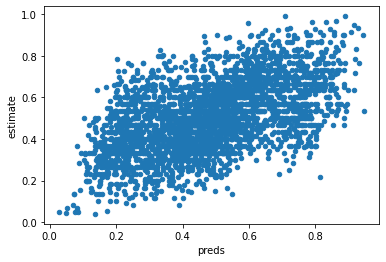

In [300]:
df_output = df
df_output["preds"] = az_data_rf.posterior_predictive.mean(dim=['chain', 'draw']).yhat
print("corr = ", np.round(np.corrcoef(df_test.estimate, df_test.preds)[0,1],3))
df_output.plot.scatter(x = "preds", y = "estimate")

corr =  0.678


<AxesSubplot:xlabel='mean_pred', ylabel='mean_est'>

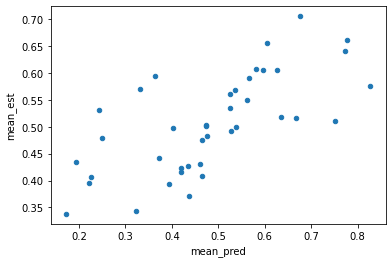

In [301]:
trial_df = df_output >> group_by(X.querytype, X.querydetail) >> summarize(mean_pred = np.mean(X.preds), mean_est = np.mean(X.estimate))
print("corr = ", np.round(np.corrcoef(trial_df.mean_est, trial_df.mean_pred)[0,1],3))
trial_df.plot.scatter(x="mean_pred", y="mean_est")

# Probability theory plus noise (PT+N) model

In [330]:
def is_cond(trial):
    return float(bool(re.search("g",trial)))


def PTN_complex(data, y=None):

    n_Ps = len(np.unique(data["subj"]))
    n_conds = len(np.unique(data["cond"]))
    trial = data["trial"]
    subj = data["subj"]
    cond = data["cond"]
    
    conditional = np.array([is_cond(t) for t in trial])
    not_conditional = abs(1-conditional)
    
    not_conjdisj = abs(1-data["conjdisj_trial"])

    # population level parameters/priors
    sigma = numpyro.sample("sigma", dist.HalfCauchy(.1)) # for Normal() response noise version
#     k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter

    # need a beta, and N's per person
    with numpyro.plate("subj", n_Ps):
        betas = numpyro.sample("beta", dist.Uniform(0.0, 1.0)) # bounded to [0,1] as in paper
        N_deltas = numpyro.sample("N_delta", dist.HalfNormal(50))
        N_primes = numpyro.sample("N_prime", dist.HalfNormal(50))
        
        # need a theta per person-query
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    

    N = 1 + N_primes[subj] + N_deltas[subj] * not_conjdisj # they required N be at least 1, no pooling for now
    beta = betas[subj]
    d = beta/(N+2*beta)
        
    theta_ind = ((subj*2)+cond)
    theta = thetas[theta_ind,:]
    
    ## 3/24/21, 10:47 AM - believe this is working but need to somehow check all of this
    p_numerator = jnp.sum(theta*data["X_num"], axis=-1) #  = P(A & B)
    pA_or_B = jnp.sum(theta * jnp.logical_or(data["X_num"], data["X_denom"]).astype("float32"), axis=-1) # = P(A or B)
    
    pB = jnp.sum(theta*data["X_denom"], axis=-1)
    
    numerator = ((1 - 2*d)*(pA_or_B - p_numerator) + d)*conditional + ((1 - 2*d)*p_numerator + d)*not_conditional
    denom = ((1 - 2*d)*pB  + d)*conditional + pB*not_conditional # should work
    
    p_ptn = jnp.divide(numerator, denom) # move division to after noise is added

    with numpyro.plate("data", len(trial)):
        yhat = numpyro.sample("yhat", dist.Normal(p_ptn, sigma), obs = y) # wrong but replicates paper
#         yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)
    
    return yhat

In [331]:
mcmc_ptn = MCMC(NUTS(PTN_complex, target_accept_prob=.80), 
               num_warmup=2000, 
               num_samples=2_000, 
               num_chains=2)

mcmc_ptn.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [328]:
# mcmc_ptn.print_summary()

In [332]:
az_data_ptn = make_arviz_data(mcmc_ptn, PTN_complex, X_data) # see model_helpers.py

az.loo(az_data_ptn, scale="deviance")

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:656: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 3360 log-likelihood matrix

             Estimate       SE
deviance_loo -1920.39    84.26
p_loo          514.27        -

There has been a warning during the calculation. Please check the results.

corr =  0.427


<AxesSubplot:xlabel='preds', ylabel='estimate'>

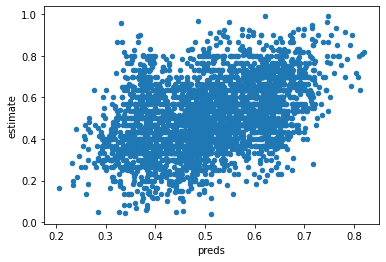

In [333]:
df_output = df
df_output["preds"] = az_data_ptn.posterior_predictive.mean(dim=['chain', 'draw']).yhat
print("corr = ", np.round(np.corrcoef(df_test.estimate, df_test.preds)[0,1],3))
df_output.plot.scatter(x = "preds", y = "estimate")